In [2]:
import numpy as np
from pyrex.main import *
from pyrex.core import *
import sxs
import matplotlib.pyplot as plt
import lal
import lalsimulation as ls
from pycbc.types import TimeSeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter.matchedfilter import make_frequency_series
from pycbc.filter import matched_filter_core,sigmasq
from pycbc.types import complex_same_precision_as

/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
_snr = None
def modify_match(vec1, vec2, vec3, vec4, psd=None, low_frequency_cutoff=None,
          high_frequency_cutoff=None, v1_norm=None, v2_norm=None):
    """ Return the match between the two TimeSeries or FrequencySeries.

    Return the match between two waveforms. This is equivalent to the overlap
    maximized over time and phase.

    Parameters
    ----------
    vec1 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    vec2 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    psd : Frequency Series
        A power spectral density to weight the overlap.
    low_frequency_cutoff : {None, float}, optional
        The frequency to begin the match.
    high_frequency_cutoff : {None, float}, optional
        The frequency to stop the match.
    v1_norm : {None, float}, optional
        The normalization of the first waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.
    v2_norm : {None, float}, optional
        The normalization of the second waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.

    Returns
    -------
    match: float
    index: int
        The number of samples to shift to get the match.
    """
    
    htilde = make_frequency_series(vec1)    
    stilde = make_frequency_series(vec2)
    h_imag=make_frequency_series(vec3)*1j
    s_im=make_frequency_series(vec4)*1j
    htilde=htilde+h_imag
    stilde=stilde+s_im

    N = (len(htilde)-1) * 2

    global _snr
   
    if _snr is None or _snr.dtype != htilde.dtype or len(_snr) != N:
        _snr = np.zeros(N,dtype=complex_same_precision_as(vec1))
   
    snr, a, snr_norm = matched_filter_core(htilde,stilde,psd,low_frequency_cutoff,high_frequency_cutoff, v1_norm, out=None)
    maxsnr, max_id = snr.abs_max_loc()
    if v2_norm is None:
        v2_norm = sigmasq(stilde, psd, low_frequency_cutoff, high_frequency_cutoff)
    return maxsnr * snr_norm / np.sqrt(v2_norm), max_id

def resizeWave(time,strain,newtime,samplerate):  
    deltaT=1./samplerate
    newtime=np.arange(min(newtime),max(newtime),deltaT)
    inter_real=spline(time,np.real(strain))
    inter_im=spline(time,np.imag(strain))
    time_real=TimeSeries(inter_real(newtime),delta_t=deltaT)
    time_im=TimeSeries(inter_im(newtime),delta_t=deltaT)
    return time_real,time_im

def compute_match(testtime,testh,timemodel,mdlh,newtm,samplerate, f_higher):
    nrdt,nid=resizeWave(testtime,testh,newtm,samplerate)
    mdt,mdi=resizeWave(timemodel,mdlh,newtm,samplerate)    
    f_lower=25.
    tlen=len(nrdt)
    delta_f = 1.0 / nrdt.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_lower)
    cmatch=modify_match(nrdt,mdt,nid,mdi,psd=psd,low_frequency_cutoff=f_lower, high_frequency_cutoff=f_higher)
    return cmatch[0]

In [4]:
name=[]
name.append(['SXS:BBH:0180','SXS:BBH:1355','SXS:BBH:1357','SXS:BBH:1358','SXS:BBH:1359','SXS:BBH:1360','SXS:BBH:1361','SXS:BBH:1362','SXS:BBH:1363'])
name.append(['SXS:BBH:0184','SXS:BBH:1364','SXS:BBH:1365','SXS:BBH:1366','SXS:BBH:1367','SXS:BBH:1368','SXS:BBH:1369'])
name.append(['SXS:BBH:0183','SXS:BBH:1372','SXS:BBH:1373','SXS:BBH:1374'])

e_comm=[]
e_comm.append([0,0.053,0.097,0.099,0.100,0.142,0.144,0.189,0.192])
e_comm.append([0,0.044,0.06,0.095,0.096,0.097,0.185])
e_comm.append([0,0.092,0.093,0.18]) #Hinder Phys Rev D 98 2018

l_comm=[]
l_comm.append([0.667,-2.788,1.371,-1.742,2.743,2.178,1.550,1.042,0.732])
l_comm.append([-0.604,2.144,1.938,1.013,-0.709,-1.963,-1.465])
l_comm.append([1.818,2.998,1.677,-0.265]) #Hinder Phys Rev D 98 201

q=[]
q.append(list(np.ones(len(e_comm[0]))+0))
q.append(list(np.ones(len(e_comm[1]))+1))
q.append(list(np.ones(len(e_comm[2]))+2))

data={}
data['name']=name[0]+name[1]+name[2]
data['e_comm']=e_comm[0]+e_comm[1]+e_comm[2]
data['q']=q[0]+q[1]+q[2]
data['l_comm']=l_comm[0]+l_comm[1]+l_comm[2]

data_training={}
data_training['name']=np.concatenate([data['name'][:3],data['name'][7:11],data['name'][14:17],data['name'][18:]])
data_training['e_comm']=np.concatenate([data['e_comm'][:3],data['e_comm'][7:11],data['e_comm'][14:17],data['e_comm'][18:]])
data_training['q']=np.concatenate([data['q'][:3],data['q'][7:11],data['q'][14:17],data['q'][18:]])
data_training['l_comm']=np.concatenate([data['l_comm'][:3],data['l_comm'][7:11],data['l_comm'][14:17],data['l_comm'][18:]])

data_test={}
for i in range(len(data['name'])):
    if data['name'][i] not in data_training['name']:
        data_test.setdefault('name', []).append(data['name'][i])
        data_test.setdefault('e_comm', []).append(data['e_comm'][i])
        data_test.setdefault('q', []).append(data['q'][i])
        data_test.setdefault('l_comm', []).append(data['l_comm'][i])

In [5]:
data_all = Glassware(q = data['q'], chi = 0, names = data['name'], e_ref = data['e_comm'])
training = Glassware(q = data_training['q'], chi = 0, names = data_training['name'], e_ref = data_training['e_comm'])

for i in range(len(data_all.names)):
    if data_all.names[i] not in training.names:
        data_test.setdefault('h22', []).append(data_all.h22[i])
        data_test.setdefault('time', []).append(data_all.time[i])

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


In [6]:
masses = np.linspace(25, 150, 3)
mismatches = {}
x_test=[]
for i in range(len(data['name'])):
    if data['name'][i] not in data_training['name']:
        x_test.append(data_all.x[i])

print(x_test)

for i in range(len(data_test['time'])):
    # sim = sxs.load(s, ignore_deprecation=True, extrapolation="Outer")
    eccentricity = data_test['e_comm'][i]
    x=x_test[i]
    
    spin1x, spin1z, spin1y = 0, 0, 0
    spin2x, spin2z, spin2y = 0, 0, 0

    mismatch_seob, mismatch_phen = [], []
    for total_mass in masses:
        mass1, mass2 = masses_from_q(data_test['q'][i], total_mass)
        std_phenom = {'mass1':mass1,'mass2':mass2,'eccentricity':eccentricity,'approximant':'IMRPhenomD','spin1x':spin1x,'spin1y':spin1y,'spin1z':spin1z,'spin2x':spin2x,'spin2y':spin1y,'spin2z':spin1z,'inclination':0,'distance':100.,'coa_phase':0, 'x':x}
        std_seob = {'mass1':mass1,'mass2':mass2,'eccentricity':eccentricity,'approximant':'SEOBNRv4','spin1x':spin1x,'spin1y':spin1y,'spin1z':spin1z,'spin2x':spin2x,'spin2y':spin1y,'spin2z':spin1z,'inclination':0,'distance':100.,'coa_phase':0, 'x':x}

        phen_ecc = Cookware(**std_phenom)
        seob_ecc = Cookware(**std_seob)

        scale = NR_amp_scale(total_mass, 100)
        y22 = find_Y22(0, 0)

        # t0 = sim.h.t[np.argmax(sim.h[:, sim.h.index(2, 2)])]
        # t_ref = (sim.h.t - t0) * (total_mass * lal.MTSUN_SI)
        # t_start = t_ref[0]
        # t_end = -29 * (total_mass * lal.MTSUN_SI)
        
        t_seob = seob_ecc.time
        t_phen = phen_ecc.time

        # mask_ref = t_ref <= t_end
        # mask_seob = (t_seob >= t_start) & (t_seob <= t_end)
        # mask_phen = (t_phen >= t_start) & (t_phen <= t_end)

        # print(len(t_ref[mask_ref]))
        # print(len(sim.h[:, sim.h.index(2, 2)][mask_ref]))

        mismatch_phen.append(1 - compute_match(t_phen, phen_ecc.h22 / (scale * y22), data_test['time'][i], data_test['h22'][i], [data_test['time'][i][0], data_test['time'][i][-1]], 4096, f_higher = (1/(6**(3/2)*np.pi*total_mass * lal.MTSUN_SI))))
        mismatch_seob.append(1 - compute_match(t_seob, seob_ecc.h22 / (scale * y22), data_test['time'][i], data_test['h22'][i], [data_test['time'][i][0], data_test['time'][i][-1]], 4096, f_higher = (1/(6**(3/2)*np.pi*total_mass * lal.MTSUN_SI))))
    mismatches[eccentricity] = (mismatch_phen, mismatch_seob)


[np.float64(0.14139682985076596), np.float64(0.132758281522539), np.float64(0.11027495434452218), np.float64(0.11961646851279063), np.float64(0.12375690560387184), np.float64(0.14293288752385297), np.float64(0.13819894720860718), np.float64(0.12596736778632023)]


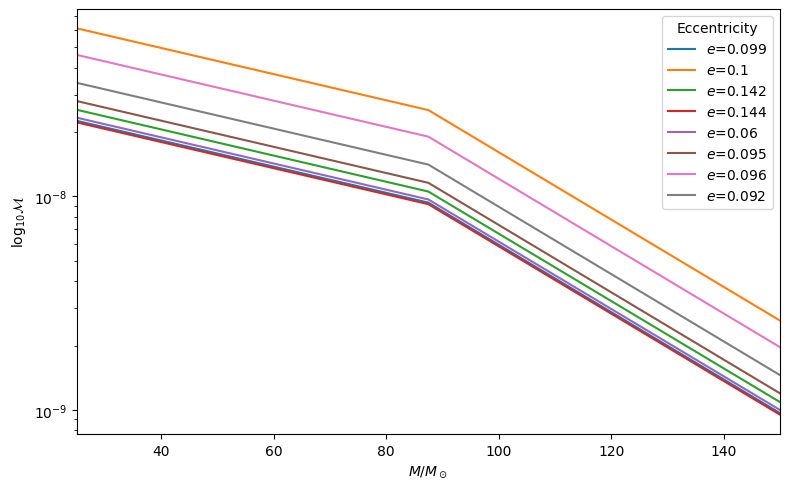

In [14]:
linestyles = {
    "SEOB": "-",
    "Phenom": "--"
}
plt.figure(figsize=(8, 5))
legend_handles = []
for eccentricity, (mismatch_phen, mismatch_seob) in mismatches.items():
    line_seob, = plt.plot(masses, mismatch_seob, linestyle=linestyles["SEOB"])
    plt.plot(masses, mismatch_phen, linestyle=linestyles["Phenom"], color=line_seob.get_color())
    legend_handles.append((line_seob, fr"$e$={eccentricity}"))

plt.legend(*zip(*legend_handles), title="Eccentricity")
plt.yscale("log")
plt.xlim(25, 150)
plt.xlabel(r"$M/M_\odot$")
plt.ylabel(r"$\text{log}_{10} \mathcal{M}$")
plt.tight_layout()
plt.show()


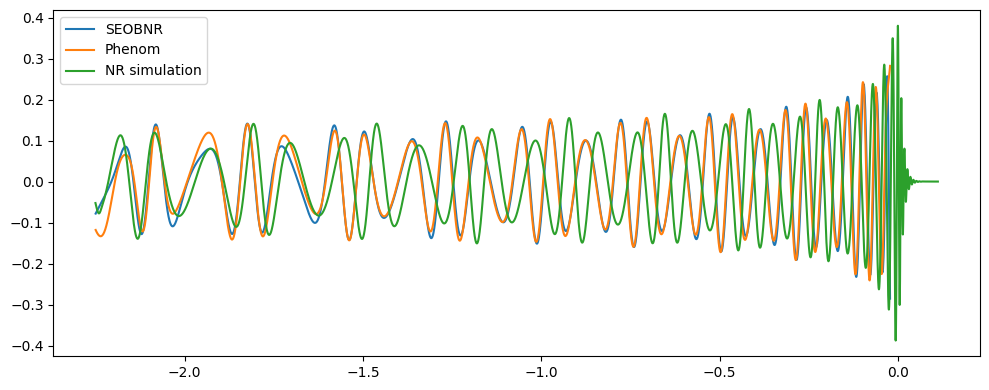

In [156]:
plt.figure(figsize=(10, 4))
plt.plot(t_seob[mask_seob], seob_ecc.h22[mask_seob] / (scale * y22), label="SEOBNR")
plt.plot(t_phen[mask_phen], phen_ecc.h22[mask_phen] / (scale * y22), label="Phenom")
plt.plot(t_ref, sim.h[:, sim.h.index(2, 2)], label="NR simulation")

plt.legend()
plt.tight_layout()
plt.show()